# setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os
# os.chdir('/Users/martinmarek/Google Drive/UCL/STAT0035/bnn-regression')
os.chdir('/content/drive/MyDrive/UCL/STAT0035/bnn-regression')

In [3]:
%%capture
!pip install dm-haiku

# imports

In [4]:
# system imports
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.flatten_util import ravel_pytree
import pickle

# relative imports
from core import models, distributions, datasets, utils, metrics, training

In [5]:
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

# dataset

In [6]:
ds_path = 'naval_dataset/data.txt'
key = jax.random.PRNGKey(0)
(x_train, y_train), (x_test, y_test) = datasets.load_naval_dataset(ds_path, key)
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(10740, 14) (10740,) (1194, 14) (1194,)


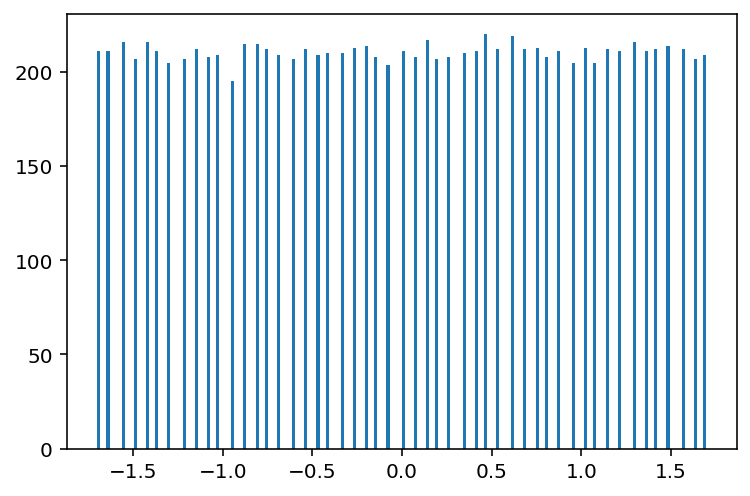

In [7]:
plt.hist(y_train, bins=200)
plt.show()

# model

In [8]:
# define model
key = jax.random.PRNGKey(0)
layer_dims = 1*[50]
init_sd = 0.1
prior_sd = 1
predict_fn, params_init = models.make_nn(key, x_train, layer_dims)
log_likelihood_fn = distributions.make_gaussian_log_likelihood(x_train, y_train, predict_fn)
log_prior_fn = distributions.make_gaussian_log_prior(prior_sd)
log_posterior_fn = distributions.make_log_posterior(log_likelihood_fn, log_prior_fn)

In [9]:
# test model
print('num. params: ', len(utils.ravel_pytree_(params_init)))
print('params: ', jax.tree_map(lambda x: x.shape, params_init))

# TEST: prior, likelihood, posterior
print('PDF test: ', log_prior_fn(params_init), log_likelihood_fn(params_init), log_posterior_fn(params_init))

num. params:  852
params:  {'linear': {'b': (50,), 'w': (14, 50)}, 'linear_1': {'b': (2,), 'w': (50, 2)}}
PDF test:  -1199.1082 -78691.375 -79890.484


# training

In [10]:
# create multiple chains using each method to allow cmputing r_hat
n_chains = 3

# number of samples to keep from each chain
n_samples = 200

# define functions to map params as pytrees <-> arrays
unravel_fn = ravel_pytree(params_init)[1]

## SGD

In [11]:
%%time
sgd_n_epochs = 10_000
sgd_ll_start = 1e-5
sgd_ll_stop = 1e-8
key = jax.random.PRNGKey(0)
chains_sgd, sgd_loss = training.create_sgd_chains(key, log_posterior_fn, params_init, init_sd, sgd_n_epochs, sgd_ll_start, sgd_ll_stop, n_chains, n_samples)

CPU times: user 7.65 s, sys: 4.06 s, total: 11.7 s
Wall time: 15.9 s


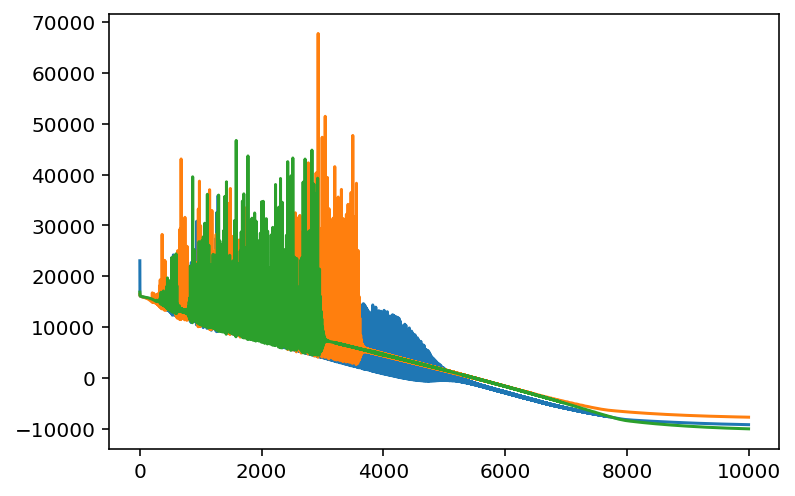

In [12]:
fig, ax = plt.subplots()
for i in range(n_chains):
    ax.plot(sgd_loss[i], alpha=1)
plt.show()

## RWMH

In [13]:
%%time
step_size = 1e-4
n_blind_steps = 10_000
key = jax.random.PRNGKey(0)
chains_rwmh, avg_accept_prob = training.create_rwmh_chains(key, log_posterior_fn, params_init, init_sd, sgd_n_epochs, sgd_ll_start, sgd_ll_stop, step_size, n_blind_steps, n_chains, n_samples)
print(f'Avg. accept. prob.: {avg_accept_prob:.2%}')

Avg. accept. prob.: 0.28%
CPU times: user 8min 10s, sys: 1min 36s, total: 9min 47s
Wall time: 10min 1s


## HMC

In [14]:
%%time
step_size = 5e-6
n_leapfrog_steps = 1_000
key = jax.random.PRNGKey(0)
chains_hmc, avg_accept_prob = training.create_hmc_chains(key, log_posterior_fn, params_init, init_sd, sgd_n_epochs, sgd_ll_start, sgd_ll_stop, step_size, n_leapfrog_steps, n_chains, n_samples)
print(f'Avg. accept. prob.: {avg_accept_prob:.2%}')

Avg. accept. prob.: 62.34%
CPU times: user 3min 21s, sys: 2min 57s, total: 6min 18s
Wall time: 6min 16s


## mixed training

In [15]:
%%time
n_outer_steps = 5
n_inner_steps = n_samples // n_outer_steps
key = jax.random.PRNGKey(0)
chains_mixed, avg_accept_prob = training.create_mixed_chains(key, log_posterior_fn, params_init, init_sd, sgd_n_epochs, sgd_ll_start, sgd_ll_stop, step_size, n_leapfrog_steps, n_chains, n_outer_steps, n_inner_steps)
print(f'Avg. accept. prob.: {avg_accept_prob:.2%}')

Avg. accept. prob.: 98.51%
CPU times: user 2min 27s, sys: 2min 43s, total: 5min 10s
Wall time: 5min 12s


## save training output

In [16]:
chains_dict = {
    'sgd': chains_sgd,
    'rwmh': chains_rwmh,
    'hmc': chains_hmc,
    'mixed': chains_mixed,
}
os.makedirs('tmp', exist_ok=True)
with open('tmp/chains_dict.npy', 'wb') as file:
    pickle.dump(chains_dict, file)

# load training output

In [17]:
with open('tmp/chains_dict.npy', 'rb') as file:
    chains_dict = pickle.load(file)

# diagnostics

## history of a single parameter

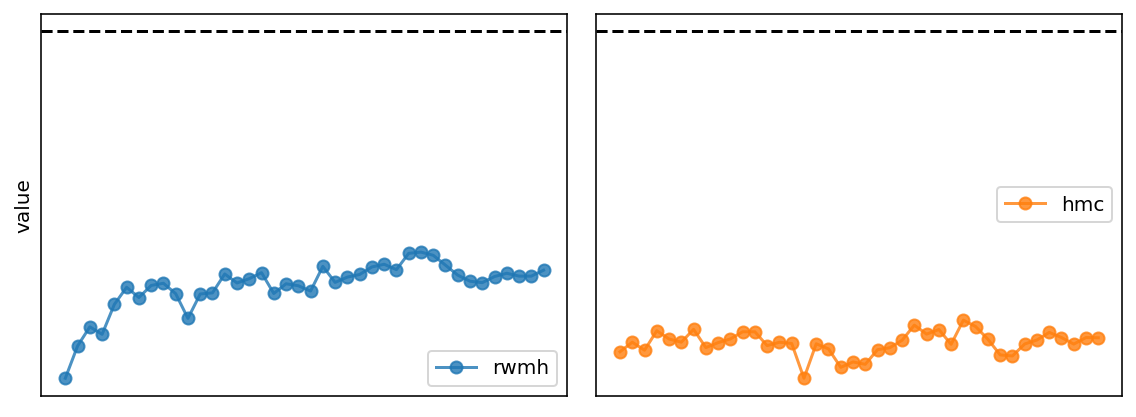

In [18]:
chain_idx = 0
param_idx = 0
n_points = 40
fig, axs = plt.subplots(1, 2, figsize=[8, 3])
axs = axs.flatten()
chains_to_show = ['rwmh', 'hmc']
for i, name in enumerate(chains_to_show):
    chains = chains_dict[name]
    param = chains[chain_idx, :, param_idx]
    line, = axs[i].plot(param[:n_points].tolist(), 'o-', alpha=0.8, label=name, color=f'C{i}')
    axs[i].axhline(y=chains[:, :, param_idx].mean(), linestyle="--", color='black')
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    axs[i].legend()
    if i in [2, 3]: axs[i].set_xlabel('step')
    if i in [0, 2]: axs[i].set_ylabel('value')
plt.tight_layout()
# plt.savefig('plots/mh_parameter_history.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## autocorrelation

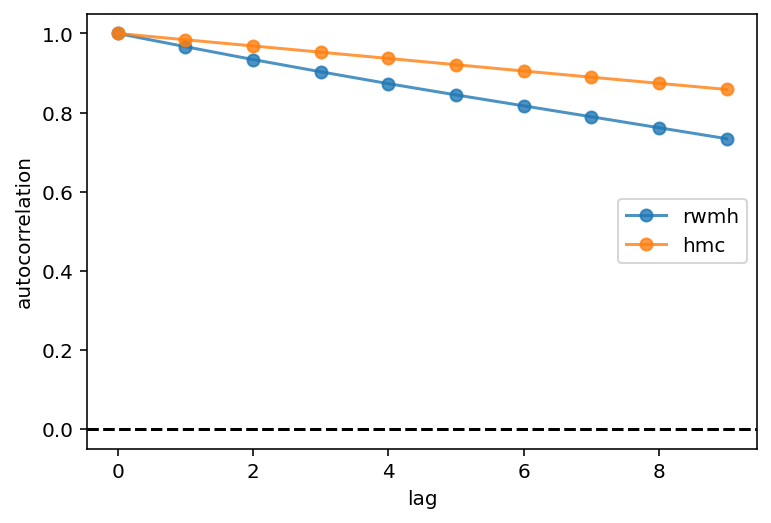

In [19]:
fig, ax = plt.subplots()

# autocorrelation
f = lambda x: x
chains_to_show = ['rwmh', 'hmc']
for i, name in enumerate(chains_to_show):
    chains = chains_dict[name]
    r = metrics.autocorr(chains, f, 10)
    ax.plot(r.tolist(), 'o-', alpha=0.8, label=name)
    ax.axhline(y=0, color='black', linestyle="--")
ax.legend()
ax.set_xlabel('lag')
ax.set_ylabel('autocorrelation')

# plt.savefig('plots/rhat_autocorr.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## $\hat{R}$

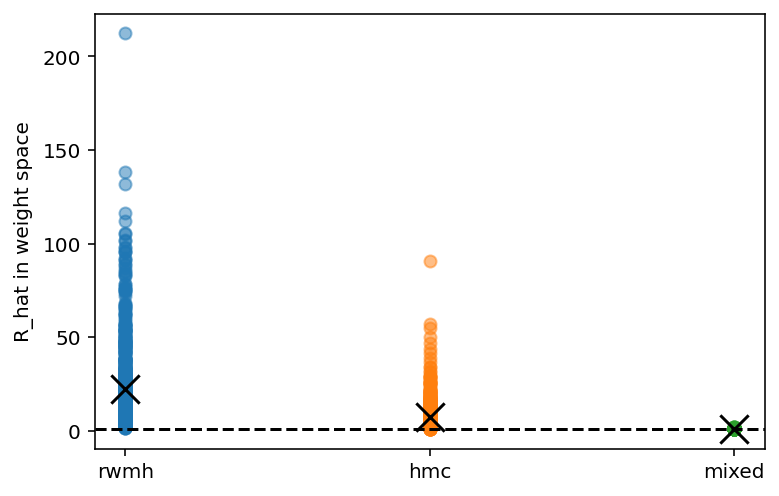

In [20]:
fig, ax = plt.subplots()

# R_hat
f = lambda x: x
chains_to_show = ['rwmh', 'hmc', 'mixed']
for i, name in enumerate(chains_to_show):
    chains = chains_dict[name]
    r = metrics.r_hat(chains, f)
    ax.scatter([i]*len(r), r.tolist(), alpha=0.5)
    ax.scatter(i, r.mean(), color='black', marker='x', s=200, zorder=2)
ax.set_xticks(range(len(chains_to_show)))
ax.set_xticklabels(chains_to_show)
ax.set_ylabel('R_hat in weight space')
ax.axhline(y=1, color='black', linestyle="--")

# plt.savefig('plots/rhat_autocorr.pdf', bbox_inches='tight', pad_inches=0)
# ax.set_yscale('log')
# ax.set_ylim([0.99, 1.16])
plt.show()

## Likelihood of test data

In [21]:
# function like 'predict_fn' but takes in an array an unravels it
def predict_from_array(x, params_flat):
    params_tree = unravel_fn(params_flat)
    y_hat = predict_fn(x, params_tree)
    return y_hat


def chain_to_loglike(chain):
    # compute y_hat for each node in the chain
    predict_vmap = jax.vmap(predict_from_array, [None, 0])
    y_hat = predict_vmap(x_test, chain)
    mean, std = y_hat[:, :, 0], y_hat[:, :, 1]

    # compute likelihood for each node in the chain
    log_likelihood = distributions.gaussian_log_pdf(y_test[None, :], mean, std)

    # average the likelihood across nodes
    log_likelihood = jax.scipy.special.logsumexp(log_likelihood, 0) - jnp.log(len(chain))

    # get total likelihood of all data points
    log_likelihood = log_likelihood.sum()
    return log_likelihood


for i, (name, chains) in enumerate(chains_dict.items()):    
    ll = jax.vmap(chain_to_loglike)(chains)
    print(f'{name}: {ll.mean():.3f} ± {ll.std():.4f}')

sgd: 1084.895 ± 117.4253
rwmh: 2211.778 ± 119.6906
hmc: 4351.113 ± 76.8623
mixed: 2531.741 ± 87.3177


## Distribution of parameters

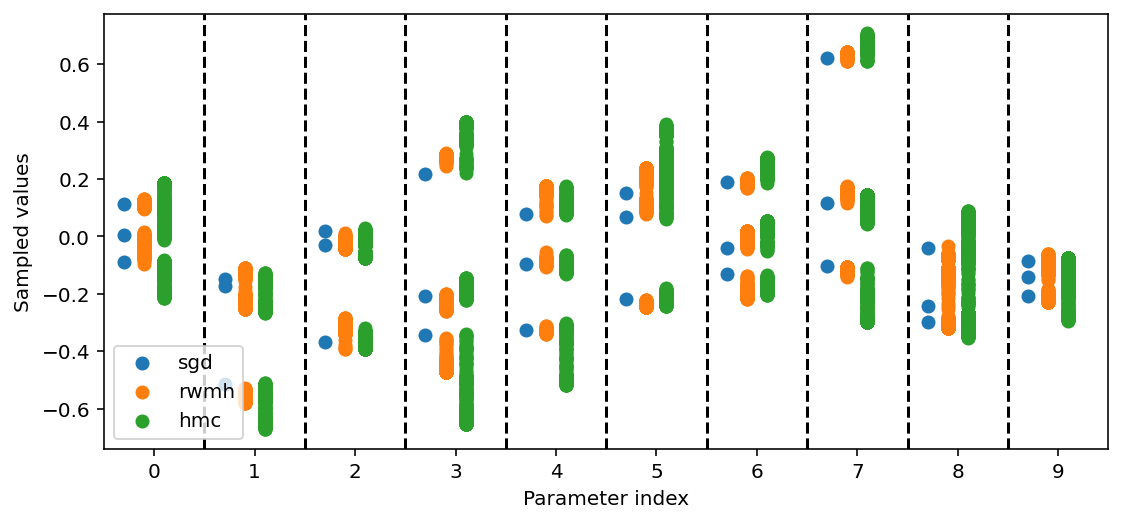

In [22]:
fig, ax = plt.subplots(figsize=[9, 4])
d = 10 # num. of params to plot
chains_to_show = ['sgd', 'rwmh', 'hmc']
for i, name in enumerate(chains_to_show):
    chains = chains_dict[name]
    M, N, D = chains.shape
    y_ = chains.reshape([M*N, D])[:, :d]
    x_ = jnp.zeros([len(y_), 1]) + jnp.arange(d)[None] + (0.2*i - 0.3)
    ax.scatter(x_, y_, c=f'C{i}', alpha=1, label=name)

for i in range(d-1):
    ax.axvline(x=i+0.5, linestyle="--", color='black')

ax.set_xlim([-0.5, d-0.5])
ax.set_xticks(range(d))
ax.set_xlabel('Parameter index')
ax.set_ylabel('Sampled values')
ax.legend(loc='lower left')
# plt.savefig('plots/parameter_distribution.pdf', bbox_inches='tight', pad_inches=0)
plt.show()